# 监督学习：回归和分类的线性模型
## 对曲线拟合的情景，实现基于线性模型的回归和分类。


### 导入必要的库

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from sklearn.model_selection import train_test_split

In [2]:
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
# plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

### 随机采样[-1,1]区间内的数，作为回归和分类训练集

In [3]:
def sampling(x, num):
    l, r = -1.3, 1.3 #左区间、右区间
    for i in range(num):
        rand_num = random.random() # 生成[0,1]之间的随机数
        mapped_num = (r - l) * rand_num + l
        x.append(mapped_num)

In [4]:
np.random.seed(77)
numbers = 100
x_regression = []
sampling(x_regression, numbers)
x_classification = []
sampling(x_classification, numbers)

In [5]:
len(x_regression), len(x_classification)

(100, 100)

### 定义一个函数，使用采样的x生成y

### 噪声分布服从于正态分布 
\begin{equation}
\label{eq1}
\epsilon \sim(\mu,\sigma) 
\end{equation}


\begin{equation}
\label{eq2}
sgn(x)=\left\{
\begin{aligned}
1 & , & x > 0, \\
-1 & , & x< 0.
\end{aligned}
\right.
\end{equation}

In [6]:
#定义噪声
def noise(mu, sigma, num):
    return np.random.normal(mu, sigma, num)
#定义sign函数
def sgn(x):
    return np.where(x > 0, 1, -1)

### 转化为numpy

In [7]:
x_regression = np.array(x_regression)
x_classification = np.array(x_classification)

### $y = 1.5 \sin(2x)+0.5\cos(-0.5x)-0.5+\epsilon$

In [9]:
#定义函数 1.5sin(2x) + 0.5cos(-0.5x)-0.5+noise x_classification
y_regression = 1.5*np.sin(2*x_regression) + 0.5*np.cos(3*x_regression)+0.25 #+ 0.5*noise(0,0.1,numbers) #0.54+0.36*x_regression+0.65*x_regression**2-0.12*x_regression**3 # #0.54+0.36*x_regression+0.65*x_regression**2-0.12*x_regression**3 #1.5*np.sin(2*x_regression) #+ 0.5*np.cos(-0.5*x_regression) -0.5 + 0.5*noise(0,0.1,numbers) 
y_classification = sgn(1.5*np.sin(2*x_classification) + 0.5*np.cos(3*x_classification)+0.25) #+ 0.5*noise(0,0.1,numbers)) #sgn(0.54+0.36*x_classification+0.65*x_classification**2-0.12*x_classification**3)# #sgn(1.5*np.sin(2*x_classification) + 0.5*np.cos(3*x_classification)+ 0.25)#sgn(1.5*np.sin(2*x_classification)) #+ 0.5*np.cos(-0.5*x_classification) -0.5 + 0.5*noise(0,0.1,numbers)) 

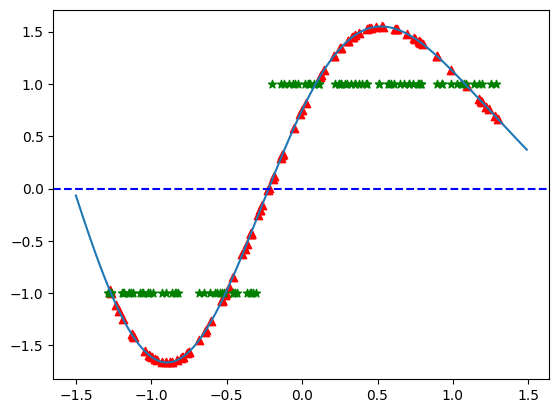

In [10]:
# 创建一个numpy数组x，范围为-10到10，步长为0.1
x = np.arange(-1.5, 1.5, 0.01)
y = 1.5*np.sin(2*x) + 0.5*np.cos(3*x)+0.25 # + 0.5*noise(0,0.1,numbers) 0.54+0.36*x+0.65*x**2-0.12*x**3##x*x*x#np.sin(4*x) #+ np.cos(-3*x)
plt.plot(x, y)
plt.scatter(x_regression, y_regression, c='r', marker='^')
plt.scatter(x_classification, y_classification, c='g', marker='*')
plt.axhline(y=0, color='b', linestyle='--')
plt.savefig('pic1.png')
plt.show()

## 设置基函数 进行特征映射

In [11]:
def power_basis(x, degree): #幂函数
    phi = np.zeros((len(x), degree+1))
    for i in range(degree+1):
        phi[:, i] = np.power(x, i)
    return phi

def gaussian_basis(x, mu, sigma):
    return np.exp(-(x-mu)**2 / (2 * sigma**2))

### 先进行幂函数映射，再加入y_label

In [12]:
x_regression_mi3 = power_basis(x_regression, 3)
x_classification_mi3 = power_basis(x_classification, 3)

x_regression_mi5 = power_basis(x_regression, 5)
x_classification_mi5 = power_basis(x_classification, 5)

x_regression_mi9 = power_basis(x_regression, 9)
x_classification_mi9 = power_basis(x_classification, 9)

x_y_regression3 = np.concatenate([x_regression_mi3,y_regression.reshape(numbers,1)],axis=1)
x_y_classification3 = np.concatenate([x_classification_mi3,y_classification.reshape(numbers,1)],axis=1)

x_y_regression5 = np.concatenate([x_regression_mi5,y_regression.reshape(numbers,1)],axis=1)
x_y_classification5 = np.concatenate([x_classification_mi5,y_classification.reshape(numbers,1)],axis=1)

x_y_regression9 = np.concatenate([x_regression_mi9,y_regression.reshape(numbers,1)],axis=1)
x_y_classification9 = np.concatenate([x_classification_mi9,y_classification.reshape(numbers,1)],axis=1)

### 再进行高斯基函数的线性映射

In [13]:
#幂函数映射，高斯函数映射
mu = np.array([-0.5,0, 0.5])  # 高斯函数的中心
sigma = 0.1
x_regression_gaussian = gaussian_basis(x_regression.reshape(numbers,1), mu, sigma)
x_classification_gaussian = gaussian_basis(x_classification.reshape(numbers,1), mu, sigma)

In [14]:
# bias = np.ones((numbers,1))
# data = np.concatenate([x_regression.reshape(numbers,1),bias],axis=1)
# data = np.concatenate([data,y_regression.reshape(numbers,1)],axis=1)
# data 

## 梯度下降算法
似然函数  
$p(\mathbf{t,s}|\mathbf{w}) = ((\prod_{i=1}^n \mathcal{N}(t_i|\phi(a_i)^T w, \beta^{-1}))((\prod_{j=1}^p \Phi(s_j \phi(b_j)^T w))$  
其对数似然函数为  
$lnp(\mathbf{t,s}|\mathbf{w}) = -\frac{\beta}{2} \sum_{i=1}^{n}(\phi(a_i)^T w - t_i)^2 + \sum_{j=1}^{p}\ln{\Phi(s_j\phi(b_j)^T w)}+const$  
我们假设先验分布为  
$p(\mathbf{w}) = \mathcal{N}(\mathbf{w}|0,\alpha^{-1}\mathbf{I})$  
因此  
$f(\mathbf{w}) = \ln{p(\mathbf{t,s}|\mathbf{w})}+\ln{p(\mathbf{w})} = -\frac{\beta}{2} \sum_{i=1}^{n}(\phi(a_i)^T w - t_i)^2 + \sum_{j=1}^{p}\ln{\Phi(s_j\phi(b_j)^T w)}- \frac{\alpha}{2}||\mathbf{w}||^2+const$  
则参数 w 可以借助最大后验法得出，即求解  
$\underset{w}{\arg \max} f(w)$，  
按照梯度上升法，迭代公式为  
$w \leftarrow w + h\nabla(w)$。  
$h > 0$为步长

因此，我们得到其对于参数$\mathbf{w}的梯度$  
$\nabla f(\mathbf{w}) = -\beta \sum_{i=1}^{m} (\phi(a_i)^T w - t_i)\phi(a_i) + \sum_{j=1}^{p} g^{'}(s_j \phi(b_j)^T w)s_j \phi(b_j) - \alpha \mathbf{w}$  
至此我们可以通过梯度下降算法迭代求解最优值$\mathbf{w}$  
$\mathbf{w} \leftarrow \mathbf{w} + h \nabla f(\mathbf{w})$

由于我在输入的时候进行了特征映射，因此我将$\phi(a_i)^T$和$\phi(b_j)^T$ 简化为$a_i$ 和 $b_j$  
$\nabla f(\mathbf{w}) = -\beta \sum_{i=1}^{m} (a_i^T w - t_i)a_i + \sum_{j=1}^{p} g^{'}(s_j b_j^T w)s_j b_j - \alpha \mathbf{w}$  

$Probit(x) = \Phi \left( z\right) =\int^{z}_{-\infty } \frac{1}{\sqrt{2\pi \sigma^{2} } } \exp \left( -\frac{z^{2}}{2} \right)$

[ 0.35181606  1.57937528 -0.20350627  0.35024867 -0.35961177 -0.04185572
  0.12091274  0.07288277  0.03718445 -0.27428645]
0.35181605954734996
1.5793752775186838
-0.20350626851493367
0.3502486726739604
-0.35961177012371714
-0.041855723608274276
0.12091274326682058
0.07288276778248816
0.037184446278731846
-0.27428644716226147
随机梯度下降法SGD最终训练的回归系数：


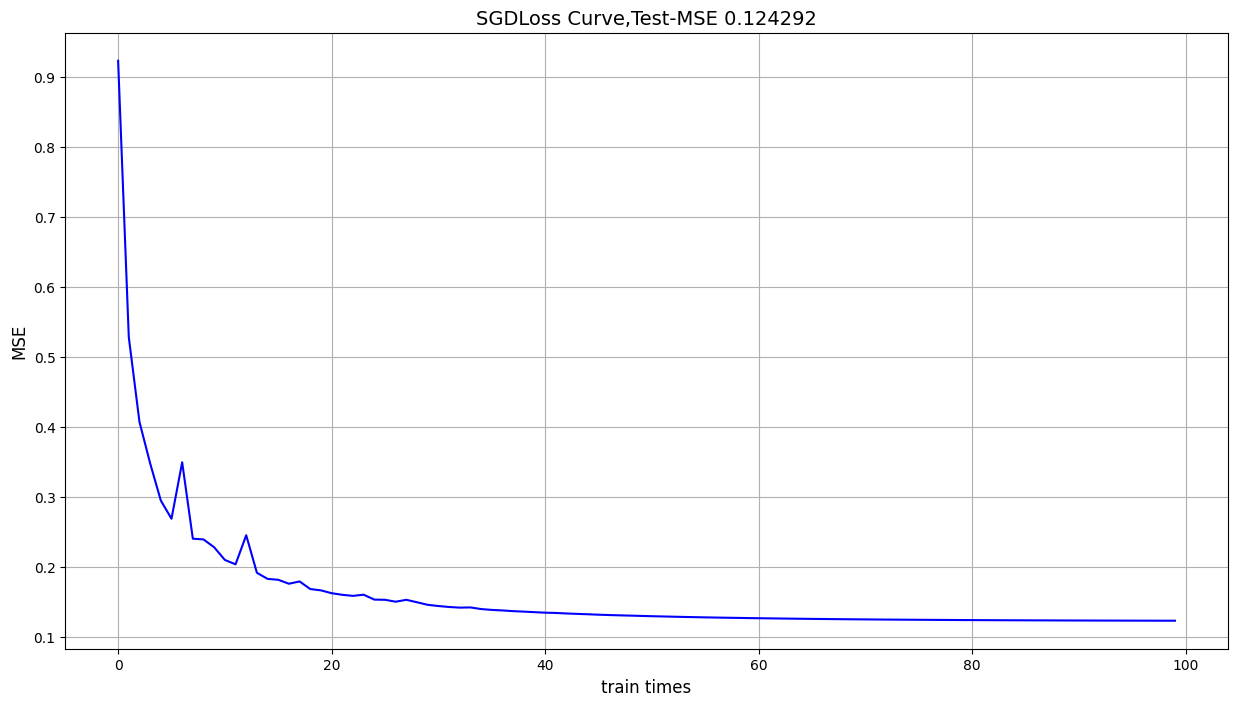

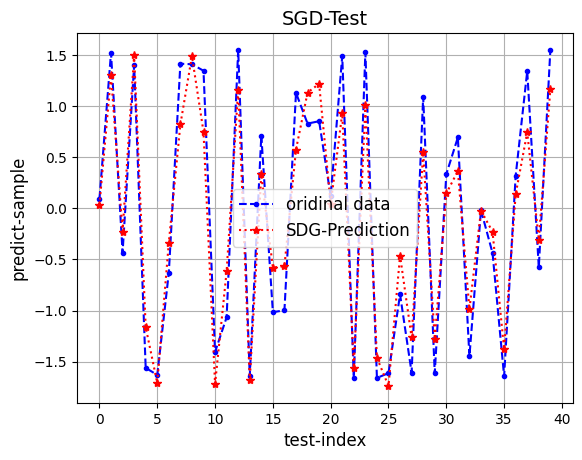

In [33]:
class GD_Linear_Model():
    def __init__(self, data, feature_list, alpha, beta, sigma):
        self.data = pd.DataFrame(data) #读取数据
        
        self.feature_labels = feature_list[:-1] #特征标签
        self.target_label = feature_list[-1] #目标值
        
        self.data_scale = self.data #StandardScaler().fit_transform(self.data) #数据标准化 
        
        self.X = np.array(self.data_scale.iloc[:, :-1])  #取X 
        self.y = np.array(self.data_scale.iloc[:, -1])  #取y

        
        self.x_train, self.x_test, self.y_train, self.y_test = \
            train_test_split(self.X, self.y, train_size=0.6, random_state=42)  #数据集划分
        
        self.alpha = alpha  #步长
        self.beta = beta #正则化因子
        self.sigma = sigma
        self.n, self.k = self.x_train.shape #训练集的大小和特征数量
        
    def sgd_regression_train(self, reweight, loop_max, threshold):
        np.random.seed(77) #设置随机数种子方便复现实验
        weight = reweight  # 使用正态分布随机初始化权重
        alpha_lr = self.alpha  # 用于衰减指数 我们先固定
        beta_lr = self.beta #用于正则化因子
        sigma_lr = self.sigma
        sdg_weight = dict()  # 存储权重更新过程值
        
        for j in range(self.k):
            sdg_weight[str(j)] = []
        train_loss_mean = []  # 存储训练过程中的误差损失
        weight_old = weight
        loop = 0  # 训练迭代变量
        for loop in range(loop_max):  # 外层循环，不断进行迭代
            alpha_lr *= 0.95  # 衰减指数0.95
            index = np.random.permutation(self.n)  # 样本索引号打乱
            train_X = self.x_train[index]  # 打乱训练数据样本
            train_y = self.y_train[index]
            for i in range(self.n):
                z = self.probit(train_X[i], weight)
                y_hat = train_X[i].dot(weight.T)
                weight = weight + alpha_lr * (-beta_lr * (y_hat - train_y[i]) * train_X[i] -  sigma_lr * weight)
            for j in range(self.k):
                sdg_weight[str(j)].append(weight[j])
            # 存储误差损失平方和平均值
            train_loss_mean.append(((train_X.dot(weight.T) - train_y) ** 2).mean()) 
            # 判断相邻两次权重更新变化，当变化小于给定阀值的时候，提前停止训练
            if np.abs(weight - weight_old).all() < threshold:
                break
            else:
                weight_old = weight

                
        print(weight) 
        for j in range(self.k):
                print(sdg_weight[str(j)][-1])
        y_test_hat, loss_test = self.predict(weight)  # 预测
        model_info_dict = self.model_info(loop + 1, train_loss_mean, sdg_weight, y_test_hat, loss_test)
        return model_info_dict
    
    def probit(self, x, w):
        # 计算Probit函数的值
        return norm.cdf(np.dot(x, w))

    def probit_gradient(self, x, w):
        # 计算Probit函数的梯度
        return norm.pdf(np.dot(x, w)) * x
    
    def sgn(self, x):
        return np.where(x > 0, 1, -1)
    
    def sgd_classification_train(self, re_weight, loop_max, threshold):
        np.random.seed(77) #设置随机数种子方便复现实验
        weight = re_weight  # 使用正态分布随机初始化权重
        alpha_lr = self.alpha  # 用于衰减指数 我们先固定
        beta_lr = self.beta #用于正则化因子
        sigma_lr = self.sigma
        sdg_weight = dict()  # 存储权重更新过程值

        for j in range(self.k):
            sdg_weight[str(j)] = []
        train_loss_mean = []  # 存储训练过程中的误差损失
        weight_old = weight
        loop = 0  # 训练迭代变量
        for loop in range(loop_max):  # 外层循环，不断进行迭代
            alpha_lr *= 0.95  # 衰减指数0.95
            index = np.random.permutation(self.n)  # 样本索引号打乱
            train_X = self.x_train[index]  # 打乱训练数据样本
            train_y = self.y_train[index]
            for i in range(self.n):                
                z = self.probit(train_X[i], weight)
                weight = weight + alpha_lr * (self.probit_gradient(train_X[i], weight) * train_y[i] / z - sigma_lr * weight)
            for j in range(self.k):
                sdg_weight[str(j)].append(weight[j])
            # 存储误差损失平方和平均值
            yes_or_no = self.sgn(train_X.dot(weight.T) * train_y)
            if np.any(yes_or_no < 0):
                train_loss_mean.append(np.mean(-np.log(yes_or_no)))
            # 判断相邻两次权重更新变化，当变化小于给定阀值的时候，提前停止训练
            if np.abs(weight - weight_old).all() < threshold:
                break
            else:
                weight_old = weight
        y_test_hat, loss_test = self.predict1(weight)  # 预测
        model_info_dict = self.model_info(loop + 1, train_loss_mean, sdg_weight, y_test_hat, loss_test) 
        return model_info_dict

    def model_info(self, loop, loss_train, weight, y_test_hat, loss_test):
        model_info_dict = dict()
        model_info_dict["loop"] = loop
        model_info_dict["loss_train"] = loss_train
        model_info_dict["weight"] = weight
        model_info_dict["y_test_hat"] = y_test_hat
        model_info_dict["loss_test"] = loss_test
        return model_info_dict

    def predict(self, weight):
        y_test_hat = self.x_test.dot(weight.T)
        loss_test = ((y_test_hat - self.y_test) ** 2).mean()
        return y_test_hat, loss_test
    
    def predict1(self, weight):
#         y_test_hat = self.sgn(self.x_test @ weight.T)
        y_test_hat = np.where(self.probit(self.x_test, weight) > 0.5, 1, -1)
        loss_test = ((y_test_hat - self.y_test) ** 2).mean()
        return y_test_hat, loss_test
    
    def classification_predict(self, weight):
        y_test_hat = self.sgn(self.x_test.dot(weight.T))  # 使用sign函数进行分类
        y_test_hat[y_test_hat == 0] = -1  # 将0标签转换为-1
        accuracy = (y_test_hat == self.y_test).mean()  # 计算分类准确率
        return y_test_hat, accuracy
    def plt_loss_weight(self, sgd_info_dict):
        def plt_loss(info_dict, title):
            plt.plot(info_dict["loss_train"], 'b-')
            plt.xlabel("train times", fontdict={"fontsize": 12})
            plt.ylabel("MSE", fontdict={"fontsize": 12})
            plt.title(title + "Loss Curve,Test-MSE %f" %
                      info_dict["loss_test"], fontdict={"fontsize": 14})
            plt.grid()

        def plt_weight(info_dict, title):
            for j in range(self.k):
                plt.plot(info_dict["weight"][str(j)], label=self.feature_labels[j])
            plt.xlabel("Weight update times", fontdict={"fontsize": 12})
            plt.ylabel("feature-weight", fontdict={"fontsize": 12})
            plt.title(title + "regression-update-curve", fontdict={"fontsize": 14})
            plt.grid()
            plt.legend(fontsize=12)

        plt.figure(figsize=(15, 8))
        plt_loss(sgd_info_dict, "SGD")
#         plt_weight(sgd_info_dict, "SGD")
        plt.show()

    def plt_predict(self, sgd_info_dict):
        # 绘制预测值与真实值对比图 #self.y
        plt.plot(self.y_test, 'b.--', label="oridinal data")
        plt.plot(sgd_info_dict["y_test_hat"], 'r*:', label="SDG-Prediction")
        plt.xlabel("test-index", fontdict={"fontsize": 12})
        plt.ylabel("predict-sample", fontdict={"fontsize": 12})
        plt.title("SGD-Test", fontdict={"fontsize": 14})
        plt.legend(fontsize=12)
        plt.grid()
        plt.show()
        
    def plt_predict1(self, sgd_info_dict):
        # 绘制预测值与真实值对比图 #self.y
        plt.plot(self.y_test, 'b.--', label="oridinal data")
        plt.plot(self.sgn(sgd_info_dict["y_test_hat"]), 'r*:', label="SDG-Prediction")
        plt.xlabel("test-index", fontdict={"fontsize": 12})
        plt.ylabel("predict-sample", fontdict={"fontsize": 12})
        plt.title("SGD-Test", fontdict={"fontsize": 14})
        plt.legend(fontsize=12)
        plt.grid()
        plt.show()

if __name__ == '__main__':
    attribute_list = ["x1","x2","x3","x4","x5","x6","x7","x8","x9","x10","y"]#["x1","x2","x3","bias","y"]
#     attribute_list = ["x1","x2","x3","x4","y"]
    
    alpha = 1e-3
    beta = 10
    sigma = 0.01
    weight = np.random.random(10)  # 使用正态分布随机初始化权重

#     data1 = x_y_classification9
#     gdlm = GD_Linear_Model(data1, attribute_list, alpha, beta, sigma)
#     sgd_info_dict = gdlm.sgd_classification_train(weight, 100, 1e-6)
#     print("=" * 70)
#     print("随机梯度下降法SGD最终训练的分类系数：")
#     for i in range(gdlm.k):
#         print(attribute_list[i], " ", sgd_info_dict["weight"][str(i)][-1])
#     print("=" * 70)
#     gdlm.plt_predict1(sgd_info_dict)
#     gdlm.plt_loss_weight(sgd_info_dict)

#     weight = []
#     for i in range(gdlm.k):
#         weight.append(sgd_info_dict["weight"][str(i)][-1]) 
#         print(attribute_list[i], " ", sgd_info_dict["weight"][str(i)][-1])
#     weight = np.array(weight)
    

    data = x_y_regression9
    gdlm = GD_Linear_Model(data, attribute_list, alpha, beta, sigma)
    sgd_info_dict = gdlm.sgd_regression_train(weight, 100, 1e-6)
    print("=" * 70)
    print("随机梯度下降法SGD最终训练的回归系数：")
    print("=" * 70)
    gdlm.plt_loss_weight(sgd_info_dict)
    gdlm.plt_predict(sgd_info_dict)
    #$0.54+0.36*x+0.65*x**2-0.12*x**3 $

$0.54+0.36*x+0.65*x**2-0.12*x**3 $

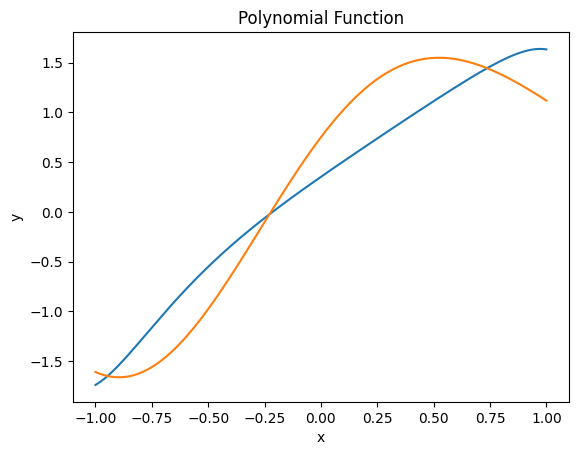

In [34]:
def polynomial(w, x):
#     y = w[0] + w[1]*x + w[2]*x**2 + w[3]*x**3
    y = w[0]*1 + w[1]*x + w[2]*x**2 + w[3]*x**3 + w[4]*x**4 + w[5]*x**5+ w[6]*x**6+ w[7]*x**7 + w[8]*x**8 + w[9]*x**9
    return y

w =[0.35181605954734996
,1.5793752775186838
,-0.20350626851493367
,0.3502486726739604
,-0.35961177012371714
,-0.041855723608274276
,0.12091274326682058
,0.07288276778248816
,0.037184446278731846
,-0.27428644716226147]

# w = [
# 0.49416828147351527
# ,1.3114752578961153
# ,0.4690221894212
# ,0.6795270762578951
# ]
x = np.linspace(-1, 1, num=1000)  # 生成100个均匀分布的x值
y = polynomial(w, x)  # 计算对应的y值
plt.plot(x, y)
y =  1.5*np.sin(2*x) + 0.5*np.cos(3*x)+0.25
plt.plot(x, y)
# 绘制图像
plt.xlabel('x')
plt.ylabel('y')
plt.title('Polynomial Function')
plt.show()

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

# 生成样本数据
X = np.linspace(-1, 1, 100)
y = 1.5*np.sin(2*X) + 0.5*np.cos(3*X) - 0.5
# 添加噪声
y_noise = y + np.random.normal(0, 0.1, 100)
X = X.reshape(-1, 1)
y_noise = y_noise.reshape(-1, 1)

# 创建多项式特征
poly_features = PolynomialFeatures(degree=5, include_bias=False)
X_poly = poly_features.fit_transform(X)

# 创建线性回归模型
lin_reg = LinearRegression()

# 模型训练
lin_reg.fit(X_poly, y_noise)

# 模型预测
X_new = np.linspace(-1, 1, 100).reshape(-1, 1)
X_new_poly = poly_features.transform(X_new)
y_pred = lin_reg.predict(X_new_poly)

# 绘图
plt.plot(X, y, 'b', label='True function')
plt.scatter(X, y_noise, c='r', label='Noisy samples')
plt.plot(X_new, y_pred, 'g-', label='Polynomial regression')
plt.legend(loc='best')
plt.show()

## K-Means:无监督学习 K-均值聚类
对MNIST数据集，实现K-均值聚类  
(1) 概述  
I 给定数据集 MNIST，不考虑标签，给定类别数 K，训练任务为：将数据聚成 K 类。  
II 考虑使用 PCA 对原始数据样本进行降维。原有样本维度 m = 28 × 28，降维之后样本维度 m（即主成分个数）根据样本累计方差贡献率进行计算，可设定累计方差贡献率阈值 = 80% 或 90%。  
(2) 数据集
从 http://yann.lecun.com/exdb/mnist/ 下载 MNIST 数据集，该数据集包含 60000 个训
练样本，10000 个测试样本，每个样本都是分辨率为 28 × 28 的图像，每幅图像的内容都
是 0 ∼ 9 这 10 个数字中的某一个，都是人工手写的，并且每个训练样本和测试样本都有
对应的标签（0 ∼ 9 中的某个数字）。图 2 给出了前 40 个测试样本。
把 MNIST 的训练集和测试集共 70000 张图片作为数据集。该数据集可写为 $\{x_i\}_{i=1}^m$，其中 $x_i \in R^{784}$，即把每幅图像按行或按列组织成一个列向量，$m = 70000$。

在算法的开始，由于我们预先知道了该图像有10个类，因此我们将K值设置为10，一般聚类问题的初值是随机设置，为了保证迭代的稳定性以及效率，我取出从10类中分别取出一个样本作为初始值开始迭代优化。

In [ ]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from PIL import Image

In [ ]:
# 加载MNIST数据集
mnist = fetch_openml('mnist_784')
# 获取MNIST数据集的图像和标签
X, y = mnist["data"], mnist["target"]
# 输出数据集的形状
print("X shape:", X.shape)
print("y shape:", y.shape)

下面使用plt随机打印两行五列的MNIST数据集，28*28

In [ ]:
plt.figure(figsize=(10, 5))
for i in range(1,11):
    plt.subplot(2, 5, i)
    plt.imshow(X[i].reshape(28, 28), cmap='gray')
plt.show()

我们使用sklearn中的数据集划分将其划分为6W张训练集和1W张测试集

In [ ]:
x_train, x_test, y_train, y_test = \
            train_test_split(X, y, train_size=6/7, random_state=42)  #数据集划分

下面考虑使用PCA进行降维处理，我们需要保证累积方差贡献值大于85%

In [ ]:
x_train.shape

## PCA算法思路
首先我们需要将每一行向量的均值归一化为0  
$X = X - \frac{1}{N} \sum_{i=1}^{m} x_i $  
其次进行构造协方差矩阵  
$ s_{ij} = \frac{1}{n-1} \sum_{k=1}^{n} (x_{ik}-\bar{x_i})(x_{jk}-\bar{x_j})$  
对协方差矩阵进行特征值分解得到特征值和特征向量  
对特征值进行排序，并计算方差贡献度

In [ ]:
def PCA(X, threshold):
    X_centered = X - np.mean(X, axis=0) # 对数据进行中心化处理
    cov = np.dot(X_centered.T, X_centered) / (X.shape[0] - 1) # 计算数据的协方差矩阵
    eigen_values, eigen_vectors = np.linalg.eig(cov) # 对协方差矩阵进行特征值分解，得到特征值和特征向量
    # 对特征值进行排序
    idx = np.argsort(eigen_values)[::-1]
    eigen_values = eigen_values[idx]
    eigen_vectors = eigen_vectors[:, idx]
    # 计算每个主成分的方差贡献率，并对其进行累加
    var_contrib = eigen_values / np.sum(eigen_values)
    cum_var_contrib = np.cumsum(var_contrib)
    # 选取方差贡献率大于等于阈值的主成分
    k = np.argmax(cum_var_contrib >= threshold) + 1
    P = eigen_vectors[:, :k] #784 * 59
    # 将数据矩阵 X 乘以投影矩阵 P，得到降维后的数据矩阵 Y
    Y = np.dot(X_centered, P) #60000 * 59
    return Y, P

Y, P = PCA(x_train, threshold=0.85) # 调用PCA函数，保留累计方差贡献率大于等于85%

# 将降维后的数据矩阵乘以投影矩阵 P 的转置加上数据矩阵的均值，得到还原后的数据矩阵 X_reconstructed
X_reconstructed = np.dot(Y, P.T) + np.mean(x_train, axis=0)

# 输出结果
print("原始数据矩阵 X：")
print(x_train.shape)
print("降维后的数据矩阵 Y：")
print(Y.shape)
print("还原后的数据矩阵 X_reconstructed：")
print(X_reconstructed.shape)

In [ ]:
Y.shape, P.shape, X_reduced.shape

In [ ]:
# 将降维后的数据反变换回原始数据
X_reconstructed = pca.inverse_transform(X_reduced)
X_reconstructed.shape

In [ ]:
def k_means_clustering(data, k, initial_centroids):
    """
    实现K均值聚类算法
    :param data: 数据集，每一行表示一个数据点
    :param k: 聚类中心数量
    :param initial_centroids: 初始聚类中心，每一行表示一个聚类中心
    :return: 聚类后的标签和聚类中心
    """
    # 将初始聚类中心设置为当前聚类中心
    centroids = initial_centroids #传入初始化聚类中心
    
    # 迭代直到收敛
    while True:
        distances = np.sqrt(((data - centroids[:, np.newaxis])**2).sum(axis=2)) # 计算每个点到所有聚类中心的距离
        labels = np.argmin(distances, axis=0) # 将每个点分配到最近的聚类中心
        new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)]) # 计算新的聚类中心
        if np.all(centroids == new_centroids):  # 如果聚类中心不再改变，则停止迭代
            break       
        centroids = new_centroids
    return labels, centroids

In [ ]:
# 生成数据集
np.random.seed(42)
X_pca_train = Y
# 设置聚类中心数量和初始聚类中心
K = 10
initial_centroids = np.array([X_pca_train[1],X_pca_train[3],X_pca_train[5],X_pca_train[7],X_pca_train[9],X_pca_train[11],X_pca_train[13],X_pca_train[15],X_pca_train[17],X_pca_train[19]])
# 运行K均值聚类算法
labels, centroids = k_means_clustering(X_pca_train, K, initial_centroids)

# 打印结果
print("聚类标签：", labels)
print("聚类中心：", centroids)

In [ ]:
x_reconstructed = np.dot(centroids[0].reshape(1,-1), P.T) + np.mean(x_train, axis=0)

In [ ]:
plt.figure(figsize=(10, 5))
for i in range(1,11):
    plt.subplot(2, 5, i)
    X_reconstructed = np.dot(centroids[i-1].reshape(1,-1), P.T) + np.mean(x_train, axis=0)
    plt.imshow(X_reconstructed.reshape(28, 28).astype('float64'), cmap='gray')
plt.show() 

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

# 定义样本数据
X = np.array([[2.5, 2.4],
              [0.5, 0.7],
              [2.2, 2.9],
              [1.9, 2.2],
              [3.1, 3.0],
              [2.3, 2.7],
              [2.0, 1.6],
              [1.0, 1.1],
              [1.5, 1.6],
              [1.1, 0.9]])

# 创建PCA对象，保留方差贡献率大于85%
pca = PCA(n_components=0.85)

# 对数据进行降维
Y = pca.fit_transform(X)

# 输出结果
print("原始数据矩阵 X：")
print(X)
print("降维后的数据矩阵 Y：")
print(Y)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 加载MNIST数据集
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
X = mnist.data / 255.0
y = mnist.target

# 定义PCA函数
pca = PCA(n_components=59, random_state=42)
X_pca = pca.fit_transform(X)

# 反变换得到重构的数据
X_reconstructed = pca.inverse_transform(X_pca)

# 将反变换后的数据可视化成一张图像
reconstructed_image = X_reconstructed[0].reshape(28, 28)
plt.imshow(reconstructed_image, cmap=plt.cm.gray)
plt.show()